## Since we will be extending our use case of Airline assistant from Day 4, therefore we copied the code from there to here for Airline assistant.

# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [ ]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [ ]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

In [ ]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [ ]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [ ]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [ ]:
get_ticket_price("London")

In [ ]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [ ]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [ ]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [ ]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

# Now Lets start building our artist function for our Agent Demo

# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [ ]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [ ]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

#### Sumamary of the above function - 
1. we are calling the openai.images.generate api here to generate an image by passing the prompt , the model name , the size of the image to be generated , response_format

2. The image generated are encoded in base64 format , therefore we have to decode it to get the image.
3. Then we create an object of BytesIO from this decoded image data.

4. Then we are returning an Object of Image for rendering the image

In [ ]:
image = artist("New York City")
display(image)

# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

We're showing 1 and 2 here, and to a lesser extent 3 and 5. In week 8 we will do the lot!

In [ ]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    print("Messages Object ")
    print(messages)
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]
    
    return history, image

# Summary of Above method -
1. we create the messages object by passing the system prompt and the history object. The history Object will be automatially passed by Gradio.
  
3. Then we call openai by passing the tools
  
4. Then we check if the finish_reason for the llm is it wants to make a tool_call , then we will unpack the message returned from the llm and make the tool call and return the response to the llm.
   
5. **Here there is one addition wherein we are creating an image of the city for which the price has to be checked by calling our artist agent.**
   ```image = artist(city)```
    This is the reason we are passing the city from the handle_tool_call function


## Note - The above code of handle_tool_call can be used in any other use case since the functionality of unpacking the message will mostly be same when invoking a tool from the llm.
 


In [ ]:
#### The below function is for displaying the image with gradio

In [ ]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

## Result -
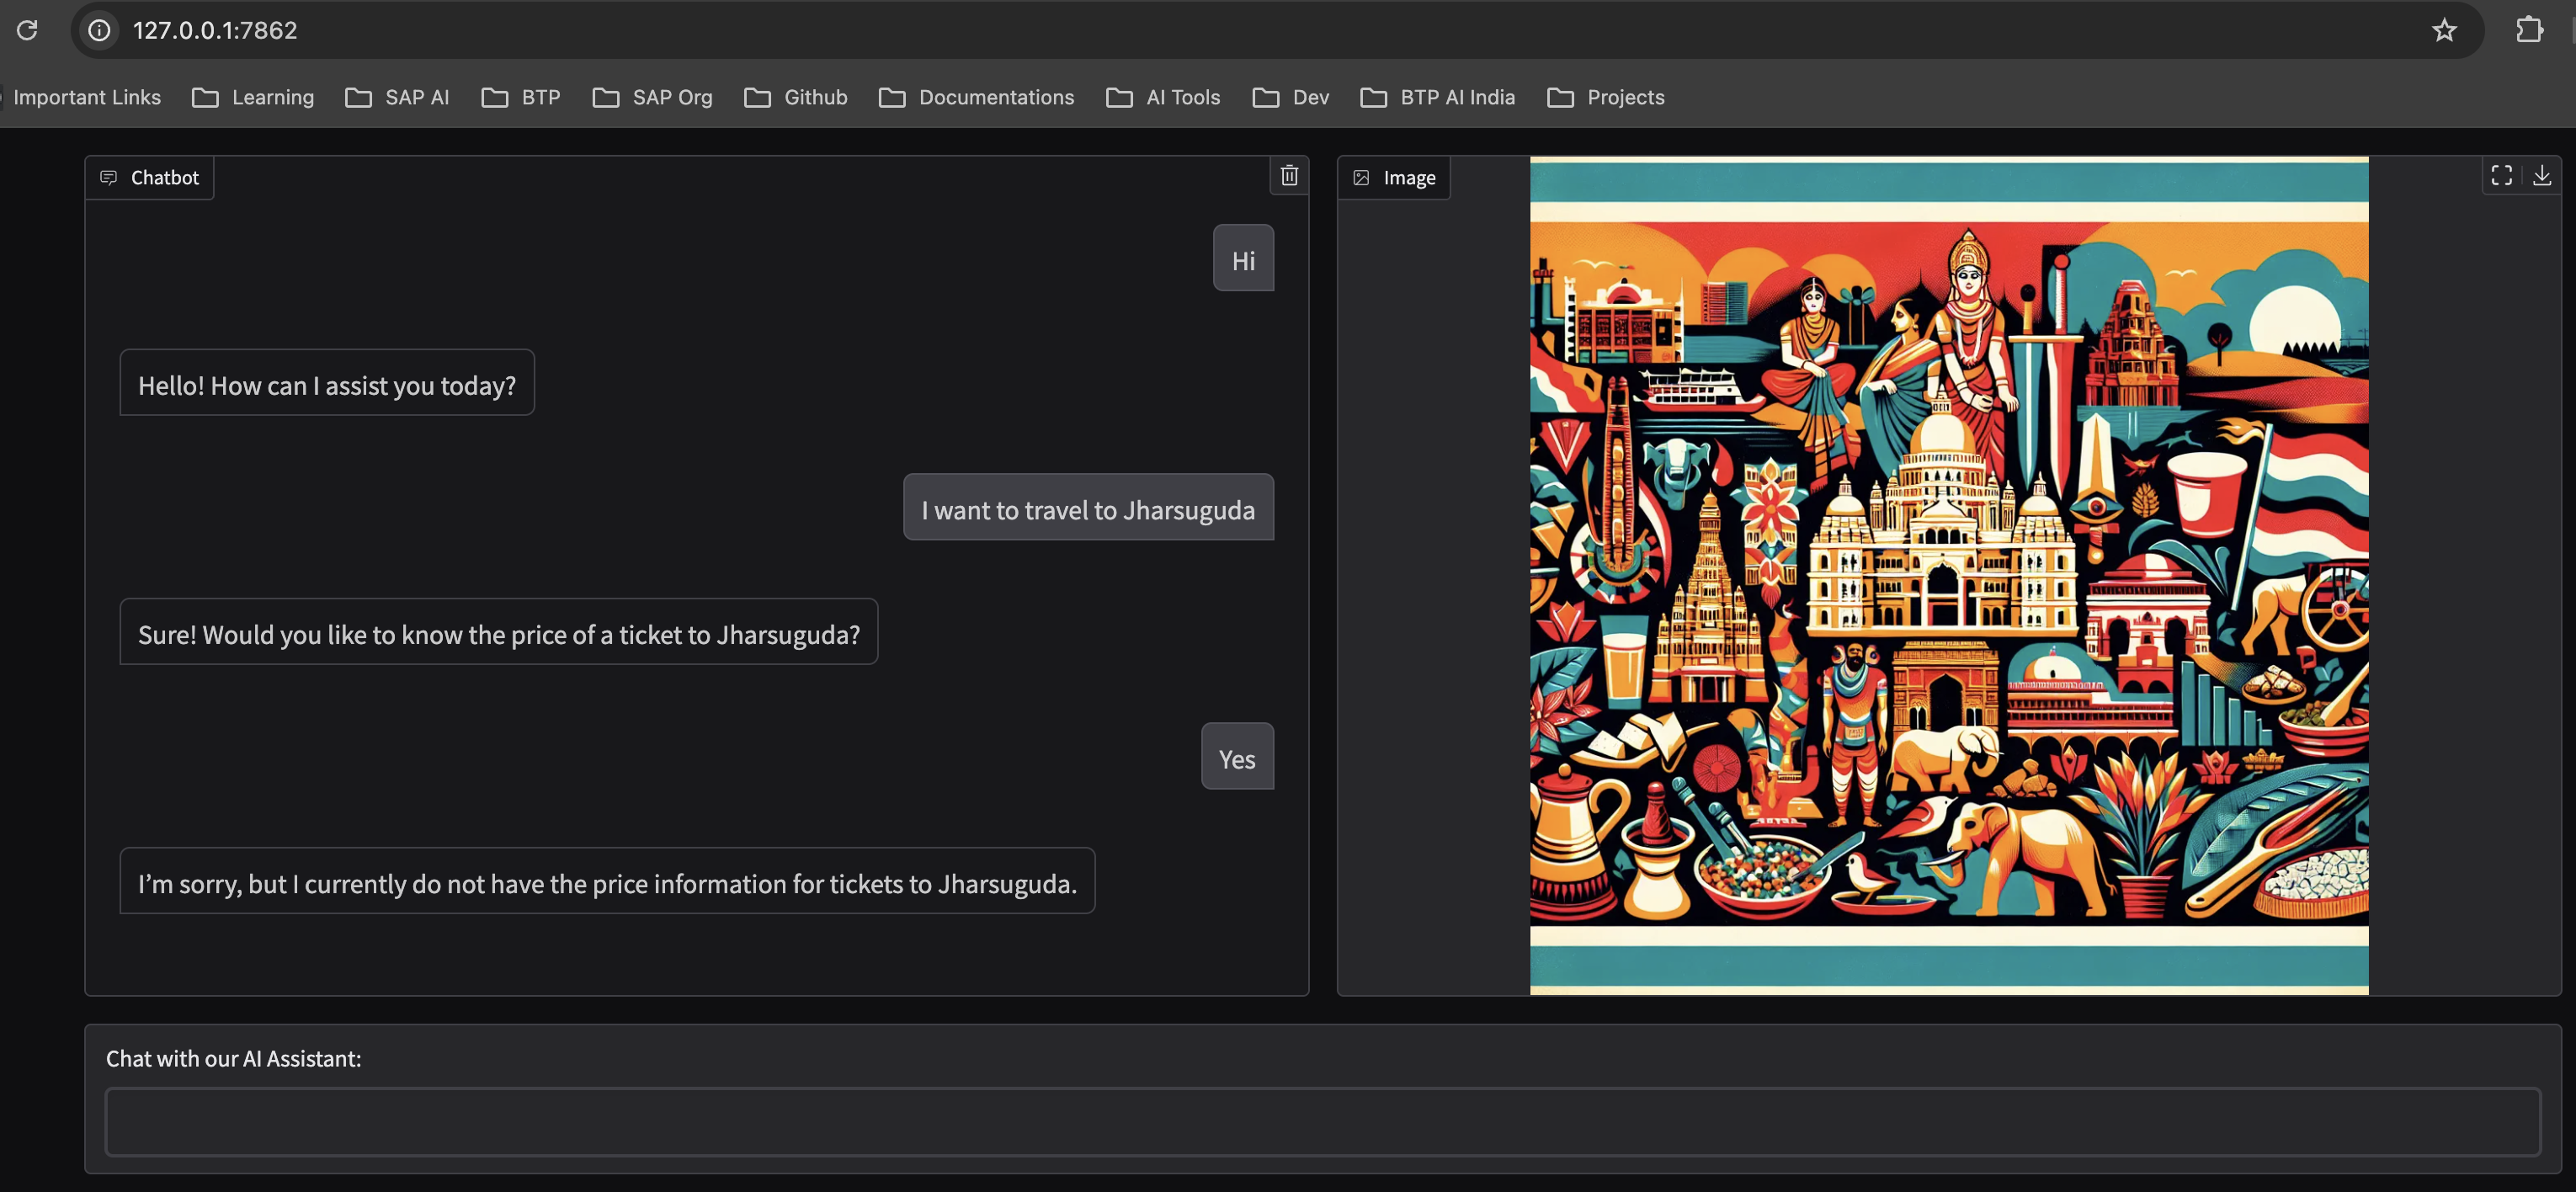

The message object for each of the message will be -
```
Messages Object 
[{'role': 'system', 'content': "You are a helpful assistant for an Airline called FlightAI. Give short, courteous answers, no more than 1 sentence. Always be accurate. If you don't know the answer, say so."}, {'role': 'user', 'metadata': None, 'content': 'Hi', 'options': None}]
Messages Object 

[{'role': 'system', 'content': "You are a helpful assistant for an Airline called FlightAI. Give short, courteous answers, no more than 1 sentence. Always be accurate. If you don't know the answer, say so."}, {'role': 'user', 'metadata': None, 'content': 'Hi', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'Hello! How can I assist you today?', 'options': None}, {'role': 'user', 'metadata': None, 'content': 'I want to travel to Jharsuguda', 'options': None}]
Messages Object 

[{'role': 'system', 'content': "You are a helpful assistant for an Airline called FlightAI. Give short, courteous answers, no more than 1 sentence. Always be accurate. If you don't know the answer, say so."}, {'role': 'user', 'metadata': None, 'content': 'Hi', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'Hello! How can I assist you today?', 'options': None}, {'role': 'user', 'metadata': None, 'content': 'I want to travel to Jharsuguda', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'Sure! Would you like to know the price of a ticket to Jharsuguda?', 'options': None}, {'role': 'user', 'metadata': None, 'content': 'Yes', 'options': None}]
Tool get_ticket_price called for Jharsuguda
```

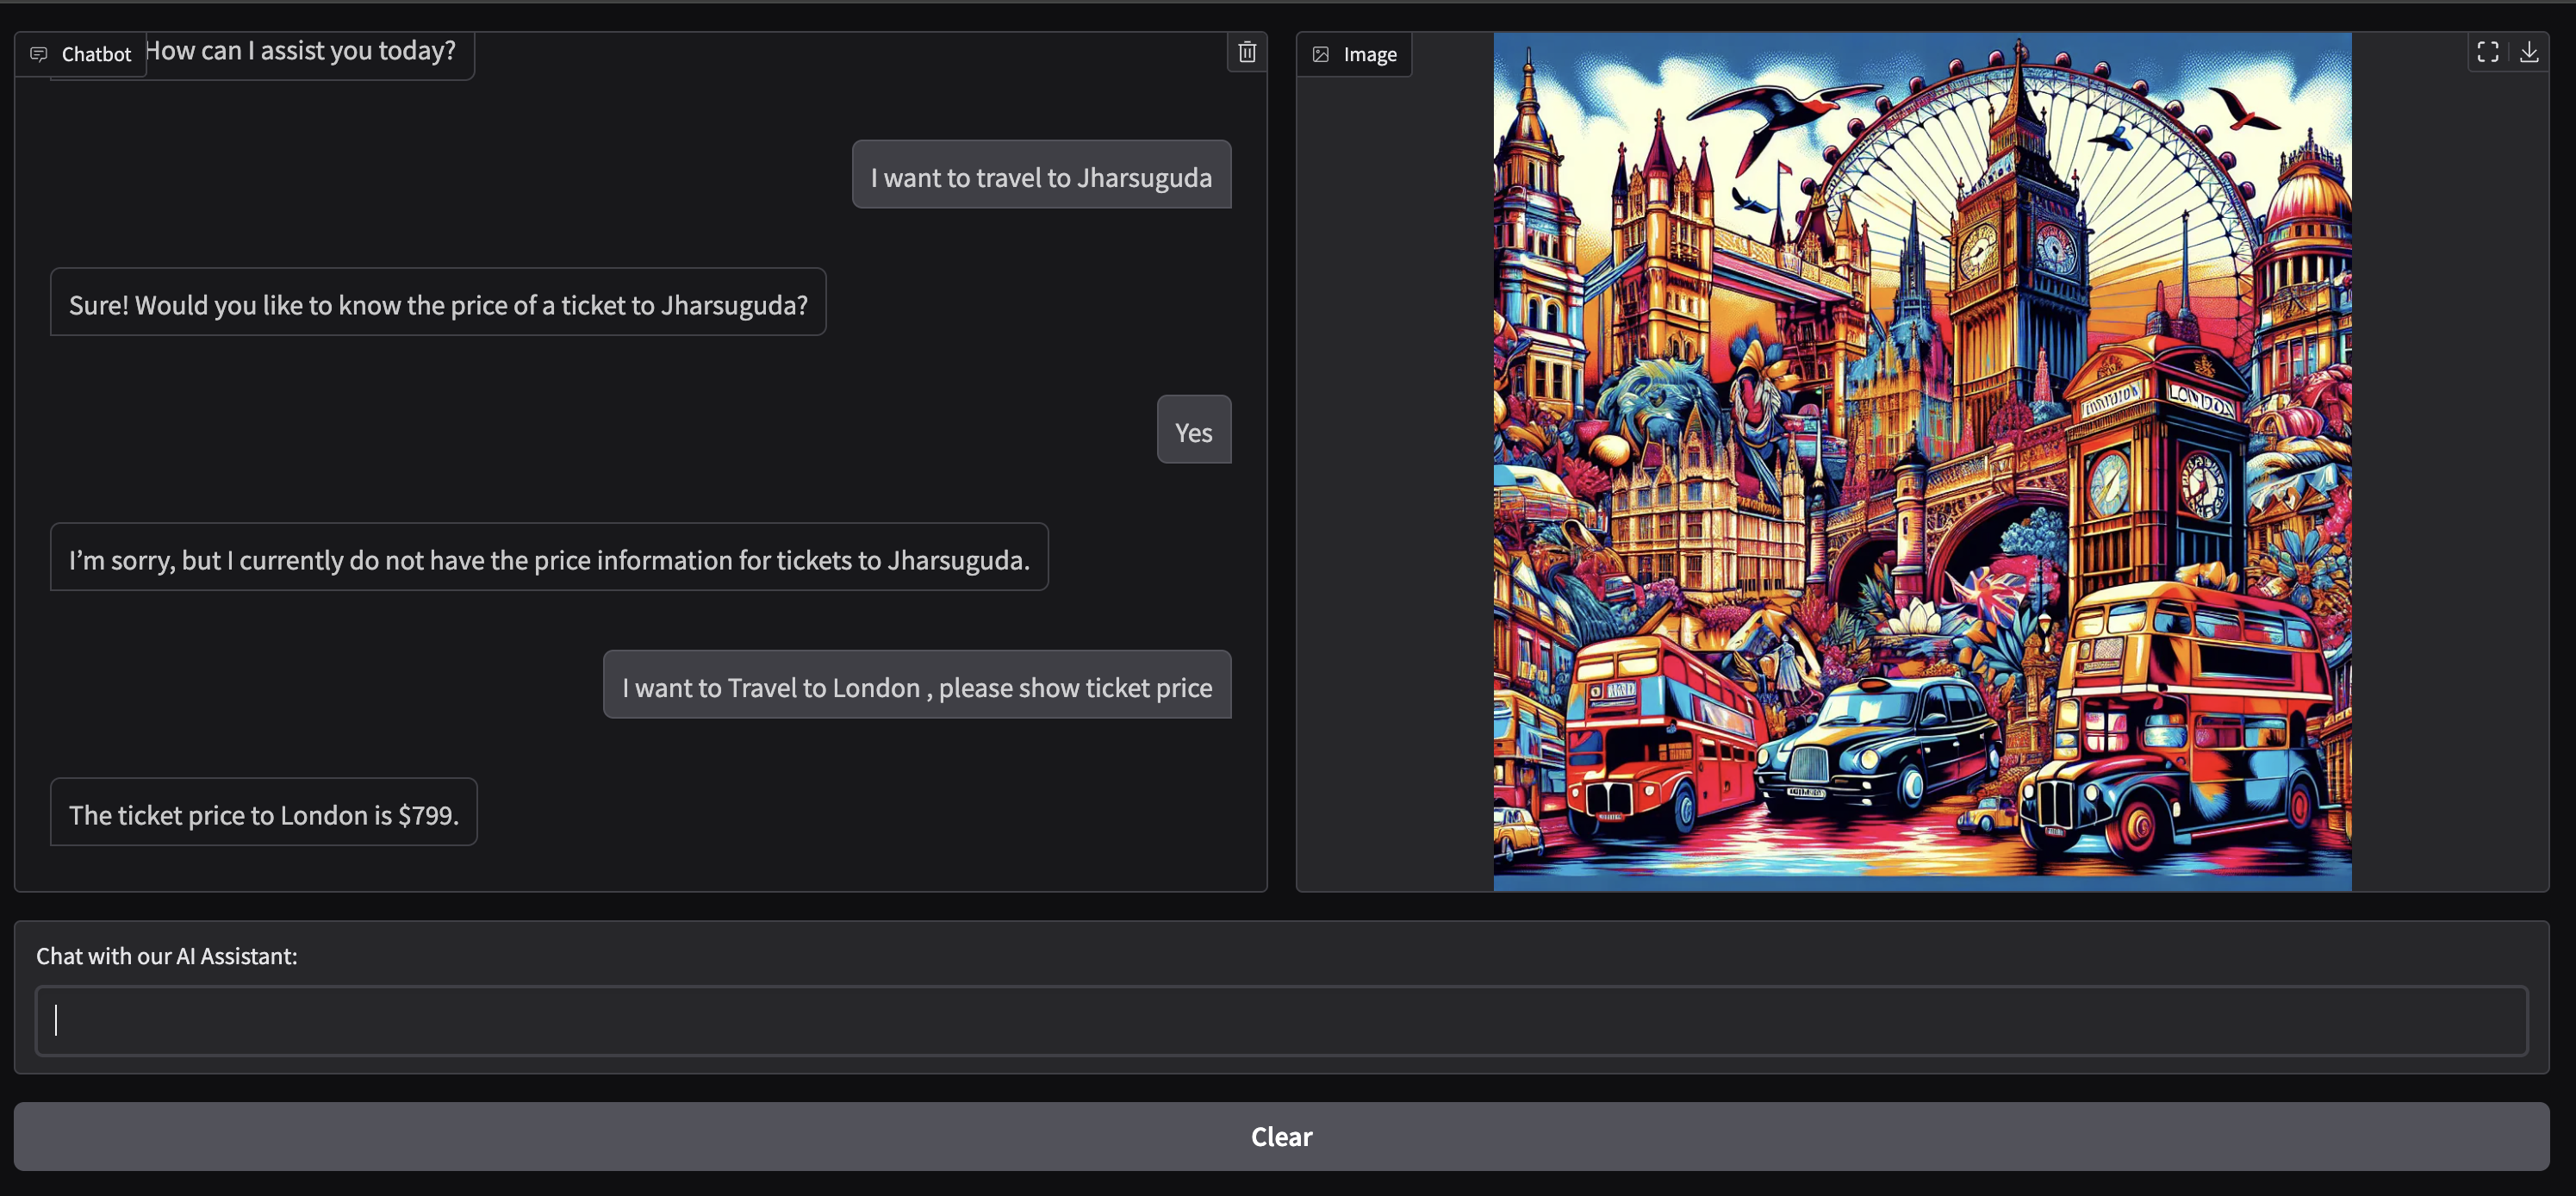

# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>